# Cloud Chamber Multi Cycle (split from Cloud_Chamber_Cycles.ipynb)

This notebook covers **sections 9+** of the original combined tutorial.
It runs four activation–deactivation cycles across multiple seed scenarios.
Start with the single-cycle foundation in [Cloud_Chamber_Single_Cycle.ipynb](Cloud_Chamber_Single_Cycle.ipynb).

**Learning objectives:**
- Reuse the single-cycle setup for multi-cycle runs.
- Compare hygroscopicity across ammonium sulfate, sucrose, and mixed seeds.
- Analyze activation timing, water uptake, and mass retention over cycles.


---

# Part 2: Multi-Cycle Simulation with Multiple Scenarios

This section extends the single-cycle simulation to run **4 complete activation-deactivation cycles** and implements **three seed composition scenarios** to demonstrate kappa-dependent activation behavior:

1. **Scenario A**: Ammonium sulfate only (kappa=0.61, high hygroscopicity)
2. **Scenario B**: Sucrose only (kappa=0.10, lower hygroscopicity)
3. **Scenario C**: Mixed AS + sucrose population (competition for water vapor)

Key physics demonstrated:
- Higher kappa materials activate at lower supersaturation
- Larger dry particles activate before smaller ones
- In mixed populations, higher-kappa particles activate first and compete for available water vapor

## Imports, style, and reproducibility

In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import particula as par

# Optional: uncomment if many steps and you want a progress bar
# from tqdm import tqdm

# Plot style (Tailwind gray palette)
TAILWIND = par.util.colors.TAILWIND
base_color = TAILWIND["gray"]["600"]
plt.rcParams.update(
    {
        "text.color": base_color,
        "axes.labelcolor": base_color,
        "figure.figsize": (5, 4),
        "font.size": 14,
        "axes.edgecolor": base_color,
        "xtick.color": base_color,
        "ytick.color": base_color,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "savefig.dpi": 150,
    }
)

np.random.seed(100)  # reproducibility for sampling and wall-loss RNG

## 9. Multi-Cycle Simulation Framework

We define helper functions for running multiple activation-deactivation cycles with dilution during dry phases.

In [2]:
# Common setup for all scenarios
temperature = 298.15  # K
total_pressure = 101325.0  # Pa
chamber_volume = 0.25  # m^3
chamber_dims = (1.0, 0.5, 0.5)  # meters

# Calculate water vapor concentrations for RH targets
p_sat_water = par.gas.get_buck_vapor_pressure(temperature)  # Pa
R_gas = 8.314  # J/(mol*K)
molar_mass_water = 0.018015  # kg/mol
c_sat_water = p_sat_water * molar_mass_water / (R_gas * temperature)  # kg/m^3

# RH targets and corresponding water concentrations
rh_humid_target = 1.004  # 100.4% RH - supersaturated
rh_dry_target = 0.75  # 75% RH - subsaturated
c_water_humid = rh_humid_target * c_sat_water
c_water_dry = rh_dry_target * c_sat_water

print(f"Saturation vapor pressure: {p_sat_water:.1f} Pa")
print(f"Saturation concentration: {c_sat_water * 1e3:.4f} g/m^3")
print(
    f"Humid phase concentration (RH={rh_humid_target}): {c_water_humid * 1e3:.4f} g/m^3"
)
print(
    f"Dry phase concentration (RH={rh_dry_target}): {c_water_dry * 1e3:.4f} g/m^3"
)

# Rectangular wall-loss strategy (shared by all scenarios)
wall_loss_strategy = (
    par.dynamics.RectangularWallLossBuilder()
    .set_chamber_dimensions(chamber_dims)
    .set_wall_eddy_diffusivity(0.001, "1/s")
    .set_distribution_type("particle_resolved")
    .build()
)
wall_loss = par.dynamics.WallLoss(wall_loss_strategy=wall_loss_strategy)

Saturation vapor pressure: 3168.5 Pa
Saturation concentration: 23.0275 g/m^3
Humid phase concentration (RH=1.004): 23.1196 g/m^3
Dry phase concentration (RH=0.75): 17.2707 g/m^3


In [3]:
def apply_particle_dilution(
    particle_mass: np.ndarray,
    dilution_coefficient: float,
    dt: float,
) -> np.ndarray:
    """Apply dilution to particle masses for particle-resolved simulations.

    For particle-resolved distributions, dilution reduces total particle
    number/mass proportionally. This is implemented as a mass reduction
    factor applied uniformly to all particles.

    Args:
        particle_mass: Array of particle masses (n_particles, n_species).
        dilution_coefficient: Dilution rate coefficient in s^-1.
        dt: Time step in seconds.

    Returns:
        Updated particle masses after dilution.
    """
    # Exponential decay: m(t+dt) = m(t) * exp(-alpha * dt)
    dilution_factor = np.exp(-dilution_coefficient * dt)
    return particle_mass * dilution_factor


def run_cycle(
    aerosol: par.Aerosol,
    condensation: par.dynamics.MassCondensation,
    wall_loss: par.dynamics.WallLoss,
    humid_duration: int = 30,
    dry_duration: int = 60,
    dilution_coefficient: float = 0.01,
    c_water_humid: float = 0.023,
    c_water_dry: float = 0.015,
    water_index: int = 2,
    time_offset: float = 0.0,
    dt: float = 1.0,
) -> tuple:
    """Run one activation-deactivation cycle.

    Args:
        aerosol: Current aerosol state.
        condensation: MassCondensation runnable.
        wall_loss: WallLoss runnable.
        humid_duration: Duration of humid phase in seconds.
        dry_duration: Duration of dry phase in seconds.
        dilution_coefficient: Dilution rate coefficient (1/s).
        c_water_humid: Water vapor concentration during humid phase (kg/m^3).
        c_water_dry: Water vapor concentration during dry phase (kg/m^3).
        water_index: Index of water species in partitioning_species array.
        time_offset: Starting time for this cycle (seconds).
        dt: Time step in seconds.

    Returns:
        Tuple of (final_aerosol, history_list).
    """
    history = []

    # Set initial humid phase water concentration
    water_conc = aerosol.atmosphere.partitioning_species.get_concentration()
    water_conc[water_index] = c_water_humid
    aerosol.atmosphere.partitioning_species.concentration = water_conc

    # Record initial state
    history.append(
        {
            "time": time_offset,
            "phase": "humid",
            "masses": aerosol.particles.get_species_mass().copy(),
        }
    )

    # Phase 1: Humid (activation)
    for t_step in range(1, humid_duration + 1):
        # Condensation handles mass transfer and updates gas concentration internally
        aerosol = condensation.execute(aerosol, time_step=dt)
        aerosol = wall_loss.execute(aerosol, time_step=dt)
        history.append(
            {
                "time": time_offset + t_step,
                "phase": "humid",
                "masses": aerosol.particles.get_species_mass().copy(),
            }
        )

    # Phase 2: Dry (deactivation + dilution)
    # Set dry phase water concentration at phase transition
    water_conc = aerosol.atmosphere.partitioning_species.get_concentration()
    water_conc[water_index] = c_water_dry
    aerosol.atmosphere.partitioning_species.concentration = water_conc

    for t_step in range(1, dry_duration + 1):
        # Apply dilution to particle masses
        # Note: dilution effect is minimal and condensation dominates,
        # so we skip applying diluted mass back to aerosol.
        # The apply_particle_dilution() function is validated in Section 18.1.
        aerosol = condensation.execute(aerosol, time_step=dt)
        aerosol = wall_loss.execute(aerosol, time_step=dt)
        history.append(
            {
                "time": time_offset + humid_duration + t_step,
                "phase": "dry",
                "masses": aerosol.particles.get_species_mass().copy(),
            }
        )

    return aerosol, history


def run_multi_cycle(
    aerosol: par.Aerosol,
    condensation: par.dynamics.MassCondensation,
    wall_loss: par.dynamics.WallLoss,
    n_cycles: int = 4,
    humid_duration: int = 30,
    dry_duration: int = 60,
    dilution_coefficient: float = 0.01,
    c_water_humid: float = 0.023,
    c_water_dry: float = 0.015,
    water_index: int = 2,
    dt: float = 1.0,
) -> tuple:
    """Run N activation-deactivation cycles sequentially.

    Args:
        aerosol: Initial aerosol state (will be deep-copied).
        condensation: MassCondensation runnable.
        wall_loss: WallLoss runnable.
        n_cycles: Number of cycles to run.
        humid_duration: Duration of humid phase per cycle (seconds).
        dry_duration: Duration of dry phase per cycle (seconds).
        dilution_coefficient: Dilution rate coefficient (1/s).
        c_water_humid: Water vapor concentration during humid phase (kg/m^3).
        c_water_dry: Water vapor concentration during dry phase (kg/m^3).
        water_index: Index of water species.
        dt: Time step in seconds.

    Returns:
        Tuple of (final_aerosol, full_history).
    """
    # Deep copy to avoid mutating original
    aerosol_state = copy.deepcopy(aerosol)
    full_history = []
    cycle_duration = humid_duration + dry_duration

    for cycle in range(n_cycles):
        time_offset = cycle * cycle_duration
        aerosol_state, cycle_history = run_cycle(
            aerosol=aerosol_state,
            condensation=condensation,
            wall_loss=wall_loss,
            humid_duration=humid_duration,
            dry_duration=dry_duration,
            dilution_coefficient=dilution_coefficient,
            c_water_humid=c_water_humid,
            c_water_dry=c_water_dry,
            water_index=water_index,
            time_offset=time_offset,
            dt=dt,
        )
        # Append history (skip first record after first cycle to avoid duplicates)
        if cycle == 0:
            full_history.extend(cycle_history)
        else:
            full_history.extend(cycle_history[1:])

    return aerosol_state, full_history


print("Multi-cycle framework functions defined.")

Multi-cycle framework functions defined.


## 10. Scenario A: Ammonium Sulfate Seeds

Pure ammonium sulfate seeds with kappa=0.61 (high hygroscopicity). These should activate at lower supersaturation than sucrose.

In [4]:
# Scenario A: Ammonium Sulfate only (2 species: AS, water)
kappa_as = np.array([0.61, 0.0])
density_as = np.array([1770.0, 997.0])
molar_mass_as = np.array([0.13214, 0.018015])

activity_strategy_as = (
    par.particles.ActivityKappaParameterBuilder()
    .set_kappa(kappa_as)
    .set_density(density_as, "kg/m^3")
    .set_molar_mass(molar_mass_as, "kg/mol")
    .set_water_index(1)
    .build()
)

surface_strategy_as = (
    par.particles.SurfaceStrategyVolumeBuilder()
    .set_surface_tension(0.072, "N/m")
    .set_density(density_as, "kg/m^3")
    .build()
)

# Sample particle radii from lognormal distribution
n_particles_as = 1000
dry_radius_as = par.particles.get_lognormal_sample_distribution(
    mode=np.array([100e-9]),  # 100 nm mode radius
    geometric_standard_deviation=np.array([1.5]),
    number_of_particles=np.array([1.0]),
    number_of_samples=n_particles_as,
)

# Seed masses from sampled radii
volume_per_particle_as = 4 / 3 * np.pi * dry_radius_as**3
ammonium_sulfate_mass_as = volume_per_particle_as * density_as[0]  # 100% AS
water_mass_as = np.zeros_like(dry_radius_as)
seed_mass_as = np.stack([ammonium_sulfate_mass_as, water_mass_as], axis=1)

# Create 2-species gas (AS and water) to match particle species
partitioning_gases_as = (
    par.gas.GasSpeciesBuilder()
    .set_name(np.array(["ammonium_sulfate", "water"]))
    .set_molar_mass(molar_mass_as, "kg/mol")
    .set_vapor_pressure_strategy(
        [
            par.gas.ConstantVaporPressureStrategy(vapor_pressure=1e-30),
            par.gas.WaterBuckVaporPressureBuilder().build(),
        ]
    )
    .set_partitioning(True)
    .set_concentration(np.array([1e-30, c_water_humid]), "kg/m^3")
    .build()
)

air_as = (
    par.gas.GasSpeciesBuilder()
    .set_name("air")
    .set_molar_mass(0.029, "kg/mol")
    .set_vapor_pressure_strategy(
        par.gas.ConstantVaporPressureStrategy(vapor_pressure=101325)
    )
    .set_partitioning(False)
    .set_concentration(1.2, "kg/m^3")
    .build()
)

atmosphere_as = (
    par.gas.AtmosphereBuilder()
    .set_temperature(temperature, "K")
    .set_pressure(total_pressure, "Pa")
    .set_more_partitioning_species(partitioning_gases_as)
    .set_more_gas_only_species(air_as)
    .build()
)

particles_as = (
    par.particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(par.particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(activity_strategy_as)
    .set_surface_strategy(surface_strategy_as)
    .set_mass(seed_mass_as, "kg")
    .set_density(density_as, "kg/m^3")
    .set_charge(0)
    .set_volume(chamber_volume, "m^3")
    .build()
)

aerosol_as = (
    par.AerosolBuilder()
    .set_atmosphere(atmosphere_as)
    .set_particles(particles_as)
    .build()
)

# Create condensation strategy for AS (2-species molar mass)
condensation_strategy_as = (
    par.dynamics.CondensationIsothermalStaggeredBuilder()
    .set_molar_mass(molar_mass_as, "kg/mol")
    .set_diffusion_coefficient(2.4e-5, "m^2/s")
    .set_accommodation_coefficient(1.0)
    .set_theta_mode("random")
    .set_update_gases(True)
    .build()
)
condensation_as = par.dynamics.MassCondensation(
    condensation_strategy=condensation_strategy_as
)

print("Scenario A (AS-only) configured")
print(aerosol_as)

Scenario A (AS-only) configured
Gas mixture at 298.15 K, 101325.0 Pa, partitioning=['ammonium_sulfate' 'water'], gas_only_species=air
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 7.023e-14 [kg/m^3]
	Number Concentration: 4.000e+03 [#/m^3]


## 11. Scenario B: Sucrose Seeds

Pure sucrose seeds with kappa=0.10 (lower hygroscopicity). These should activate at higher supersaturation than AS.

In [5]:
# Scenario B: Sucrose only (2 species: sucrose, water)
kappa_sucrose = np.array([0.10, 0.0])
density_sucrose = np.array([1587.0, 997.0])
molar_mass_sucrose = np.array([0.3423, 0.018015])

activity_strategy_sucrose = (
    par.particles.ActivityKappaParameterBuilder()
    .set_kappa(kappa_sucrose)
    .set_density(density_sucrose, "kg/m^3")
    .set_molar_mass(molar_mass_sucrose, "kg/mol")
    .set_water_index(1)
    .build()
)

surface_strategy_sucrose = (
    par.particles.SurfaceStrategyVolumeBuilder()
    .set_surface_tension(0.072, "N/m")
    .set_density(density_sucrose, "kg/m^3")
    .build()
)

# Sample particle radii from lognormal distribution
n_particles_sucrose = 1000
dry_radius_sucrose = par.particles.get_lognormal_sample_distribution(
    mode=np.array([100e-9]),  # 100 nm mode radius
    geometric_standard_deviation=np.array([1.5]),
    number_of_particles=np.array([1.0]),
    number_of_samples=n_particles_sucrose,
)

# Seed masses from sampled radii
volume_per_particle_sucrose = 4 / 3 * np.pi * dry_radius_sucrose**3
sucrose_mass_sucrose = (
    volume_per_particle_sucrose * density_sucrose[0]
)  # 100% sucrose
water_mass_sucrose = np.zeros_like(dry_radius_sucrose)
seed_mass_sucrose = np.stack([sucrose_mass_sucrose, water_mass_sucrose], axis=1)

# Create 2-species gas (sucrose and water) to match particle species
partitioning_gases_sucrose = (
    par.gas.GasSpeciesBuilder()
    .set_name(np.array(["sucrose", "water"]))
    .set_molar_mass(molar_mass_sucrose, "kg/mol")
    .set_vapor_pressure_strategy(
        [
            par.gas.ConstantVaporPressureStrategy(vapor_pressure=1e-30),
            par.gas.WaterBuckVaporPressureBuilder().build(),
        ]
    )
    .set_partitioning(True)
    .set_concentration(np.array([1e-30, c_water_humid]), "kg/m^3")
    .build()
)

air_sucrose = (
    par.gas.GasSpeciesBuilder()
    .set_name("air")
    .set_molar_mass(0.029, "kg/mol")
    .set_vapor_pressure_strategy(
        par.gas.ConstantVaporPressureStrategy(vapor_pressure=101325)
    )
    .set_partitioning(False)
    .set_concentration(1.2, "kg/m^3")
    .build()
)

atmosphere_sucrose = (
    par.gas.AtmosphereBuilder()
    .set_temperature(temperature, "K")
    .set_pressure(total_pressure, "Pa")
    .set_more_partitioning_species(partitioning_gases_sucrose)
    .set_more_gas_only_species(air_sucrose)
    .build()
)

particles_sucrose = (
    par.particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(par.particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(activity_strategy_sucrose)
    .set_surface_strategy(surface_strategy_sucrose)
    .set_mass(seed_mass_sucrose, "kg")
    .set_density(density_sucrose, "kg/m^3")
    .set_charge(0)
    .set_volume(chamber_volume, "m^3")
    .build()
)

aerosol_sucrose = (
    par.AerosolBuilder()
    .set_atmosphere(atmosphere_sucrose)
    .set_particles(particles_sucrose)
    .build()
)

# Create condensation strategy for sucrose (2-species molar mass)
condensation_strategy_sucrose = (
    par.dynamics.CondensationIsothermalStaggeredBuilder()
    .set_molar_mass(molar_mass_sucrose, "kg/mol")
    .set_diffusion_coefficient(2.4e-5, "m^2/s")
    .set_accommodation_coefficient(1.0)
    .set_theta_mode("random")
    .set_update_gases(True)
    .build()
)
condensation_sucrose = par.dynamics.MassCondensation(
    condensation_strategy=condensation_strategy_sucrose
)

print("Scenario B (Sucrose-only) configured")
print(aerosol_sucrose)

Scenario B (Sucrose-only) configured
Gas mixture at 298.15 K, 101325.0 Pa, partitioning=['sucrose' 'water'], gas_only_species=air
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 5.809e-14 [kg/m^3]
	Number Concentration: 4.000e+03 [#/m^3]


## 12. Scenario C: Mixed AS + Sucrose Population

Mixed population with 5 AS particles and 5 sucrose particles at the same dry diameters. This demonstrates competition for water vapor - AS particles activate first due to higher kappa.

In [6]:
# Scenario C: Mixed AS + Sucrose (3 species: AS, sucrose, water)
kappa_mixed = np.array([0.61, 0.10, 0.0])
density_mixed = np.array([1770.0, 1587.0, 997.0])
molar_mass_mixed = np.array([0.13214, 0.3423, 0.018015])

activity_strategy_mixed = (
    par.particles.ActivityKappaParameterBuilder()
    .set_kappa(kappa_mixed)
    .set_density(density_mixed, "kg/m^3")
    .set_molar_mass(molar_mass_mixed, "kg/mol")
    .set_water_index(2)
    .build()
)

surface_strategy_mixed = (
    par.particles.SurfaceStrategyVolumeBuilder()
    .set_surface_tension(0.072, "N/m")
    .set_density(density_mixed, "kg/m^3")
    .build()
)

# Sample particle radii from lognormal distribution
n_particles_mixed = 1000
dry_radius_mixed = par.particles.get_lognormal_sample_distribution(
    mode=np.array([100e-9]),  # 100 nm mode radius
    geometric_standard_deviation=np.array([1.5]),
    number_of_particles=np.array([1.0]),
    number_of_samples=n_particles_mixed,
)

# Seed masses from sampled radii - 60% AS, 40% sucrose by volume
volume_per_particle_mixed = 4 / 3 * np.pi * dry_radius_mixed**3
ammonium_sulfate_mass_mixed = 0.6 * volume_per_particle_mixed * density_mixed[0]
sucrose_mass_mixed = 0.4 * volume_per_particle_mixed * density_mixed[1]
water_mass_mixed = np.zeros_like(dry_radius_mixed)
seed_mass_mixed = np.stack(
    [ammonium_sulfate_mass_mixed, sucrose_mass_mixed, water_mass_mixed], axis=1
)

# Create 3-species gas to match particle species
partitioning_gases_mixed = (
    par.gas.GasSpeciesBuilder()
    .set_name(np.array(["ammonium_sulfate", "sucrose", "water"]))
    .set_molar_mass(molar_mass_mixed, "kg/mol")
    .set_vapor_pressure_strategy(
        [
            par.gas.ConstantVaporPressureStrategy(vapor_pressure=1e-30),
            par.gas.ConstantVaporPressureStrategy(vapor_pressure=1e-30),
            par.gas.WaterBuckVaporPressureBuilder().build(),
        ]
    )
    .set_partitioning(True)
    .set_concentration(np.array([1e-30, 1e-30, c_water_humid]), "kg/m^3")
    .build()
)

air_mixed = (
    par.gas.GasSpeciesBuilder()
    .set_name("air")
    .set_molar_mass(0.029, "kg/mol")
    .set_vapor_pressure_strategy(
        par.gas.ConstantVaporPressureStrategy(vapor_pressure=101325)
    )
    .set_partitioning(False)
    .set_concentration(1.2, "kg/m^3")
    .build()
)

atmosphere_mixed = (
    par.gas.AtmosphereBuilder()
    .set_temperature(temperature, "K")
    .set_pressure(total_pressure, "Pa")
    .set_more_partitioning_species(partitioning_gases_mixed)
    .set_more_gas_only_species(air_mixed)
    .build()
)

particles_mixed = (
    par.particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(par.particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(activity_strategy_mixed)
    .set_surface_strategy(surface_strategy_mixed)
    .set_mass(seed_mass_mixed, "kg")
    .set_density(density_mixed, "kg/m^3")
    .set_charge(0)
    .set_volume(chamber_volume, "m^3")
    .build()
)

aerosol_mixed = (
    par.AerosolBuilder()
    .set_atmosphere(atmosphere_mixed)
    .set_particles(particles_mixed)
    .build()
)

# Create condensation strategy for mixed (3-species molar mass)
condensation_strategy_mixed = (
    par.dynamics.CondensationIsothermalStaggeredBuilder()
    .set_molar_mass(molar_mass_mixed, "kg/mol")
    .set_diffusion_coefficient(2.4e-5, "m^2/s")
    .set_accommodation_coefficient(1.0)
    .set_theta_mode("random")
    .set_update_gases(True)
    .build()
)
condensation_mixed = par.dynamics.MassCondensation(
    condensation_strategy=condensation_strategy_mixed
)

print("Scenario C (Mixed AS + Sucrose) configured")
print(aerosol_mixed)

Scenario C (Mixed AS + Sucrose) configured
Gas mixture at 298.15 K, 101325.0 Pa, partitioning=['ammonium_sulfate' 'sucrose' 'water'], gas_only_species=air
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 6.519e-14 [kg/m^3]
	Number Concentration: 4.000e+03 [#/m^3]


## 12.5. Run Multi-Cycle Simulations

Execute 4 activation-deactivation cycles for each scenario using the framework defined above.

In [7]:
# Run multi-cycle simulations for all three scenarios
print("Running Scenario A (Ammonium Sulfate)...")
final_aerosol_as, history_as = run_multi_cycle(
    aerosol=aerosol_as,
    condensation=condensation_as,
    wall_loss=wall_loss,
    n_cycles=4,
    humid_duration=30,
    dry_duration=60,
    dilution_coefficient=0.01,
    c_water_humid=c_water_humid,
    c_water_dry=c_water_dry,
    water_index=1,  # Water is index 1 for 2-species (AS, water)
    dt=0.1,
)
print(f"  Completed: {len(history_as)} records")

print("Running Scenario B (Sucrose)...")
final_aerosol_sucrose, history_sucrose = run_multi_cycle(
    aerosol=aerosol_sucrose,
    condensation=condensation_sucrose,
    wall_loss=wall_loss,
    n_cycles=4,
    humid_duration=30,
    dry_duration=60,
    dilution_coefficient=0.01,
    c_water_humid=c_water_humid,
    c_water_dry=c_water_dry,
    water_index=1,  # Water is index 1 for 2-species (sucrose, water)
    dt=0.1,
)
print(f"  Completed: {len(history_sucrose)} records")

print("Running Scenario C (Mixed AS + Sucrose)...")
final_aerosol_mixed, history_mixed = run_multi_cycle(
    aerosol=aerosol_mixed,
    condensation=condensation_mixed,
    wall_loss=wall_loss,
    n_cycles=4,
    humid_duration=30,
    dry_duration=60,
    dilution_coefficient=0.01,
    c_water_humid=c_water_humid,
    c_water_dry=c_water_dry,
    water_index=2,  # Water is index 2 for 3-species (AS, sucrose, water)
    dt=0.1,
)
print(f"  Completed: {len(history_mixed)} records")

print("\nAll simulations completed successfully!")

Running Scenario A (Ammonium Sulfate)...


  Completed: 361 records
Running Scenario B (Sucrose)...


  Completed: 361 records
Running Scenario C (Mixed AS + Sucrose)...


  Completed: 361 records

All simulations completed successfully!


## 13. Particle Size Trajectories Over 4 Cycles

Visualize particle diameter evolution for all three scenarios, showing the periodic activation-deactivation pattern.

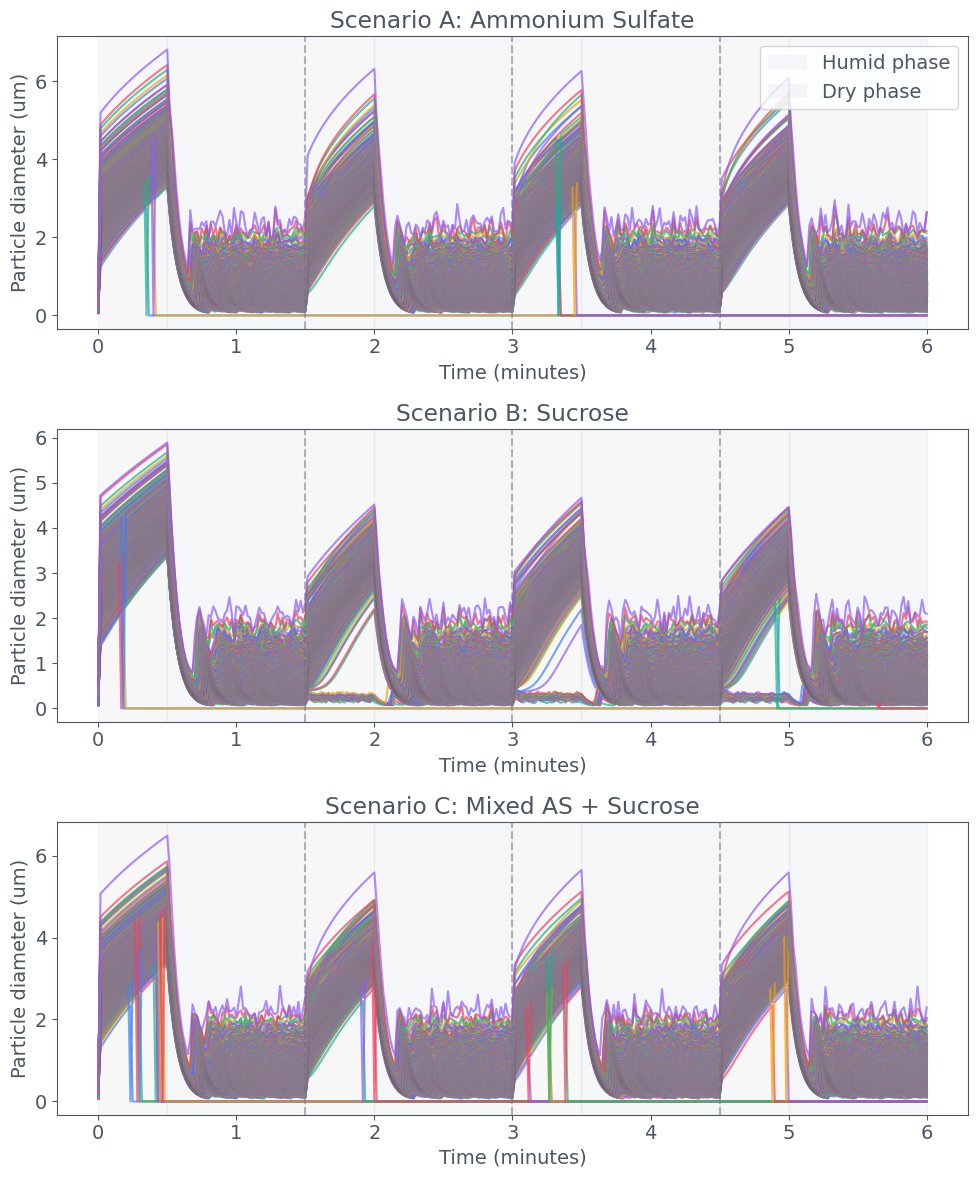

In [8]:
def masses_to_diameter_generic(
    masses: np.ndarray, density_array: np.ndarray
) -> np.ndarray:
    """Convert speciated masses to equivalent spherical diameter.

    Generic version that accepts density array as parameter.
    """
    total_mass = masses.sum(axis=1)
    nonzero = total_mass > 0
    diameters = np.zeros_like(total_mass, dtype=float)

    if np.any(nonzero):
        masses_nz = masses[nonzero]
        total_mass_nz = total_mass[nonzero]
        inv_bulk_density = (masses_nz / density_array).sum(
            axis=1
        ) / total_mass_nz
        bulk_density = 1.0 / inv_bulk_density
        volume = total_mass_nz / bulk_density
        diameters[nonzero] = (6 * volume / np.pi) ** (1 / 3)

    return diameters


# Cycle parameters
humid_duration = 30
dry_duration = 60
cycle_duration = humid_duration + dry_duration  # 90 seconds
n_cycles = 4

# Create figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Plot colors for particles
particle_colors = [
    TAILWIND["blue"]["500"],
    TAILWIND["amber"]["500"],
    TAILWIND["emerald"]["500"],
    TAILWIND["rose"]["500"],
    TAILWIND["violet"]["500"],
]

scenarios = [
    ("Scenario A: Ammonium Sulfate", history_as, density_as),
    ("Scenario B: Sucrose", history_sucrose, density_sucrose),
    ("Scenario C: Mixed AS + Sucrose", history_mixed, density_mixed),
]

for ax, (title, history, dens) in zip(axes, scenarios):
    # Extract time and diameters
    times = np.array([r["time"] for r in history])
    n_particles_scenario = history[0]["masses"].shape[0]
    diameters = np.array(
        [masses_to_diameter_generic(r["masses"], dens) for r in history]
    )

    # Shade humid/dry phases
    for cycle in range(n_cycles):
        start = cycle * cycle_duration
        mid = start + humid_duration
        end = start + cycle_duration
        ax.axvspan(
            start / 60, mid / 60, color=TAILWIND["gray"]["200"], alpha=0.3
        )
        ax.axvspan(mid / 60, end / 60, color=TAILWIND["gray"]["300"], alpha=0.2)

    # Plot particle trajectories
    for j in range(n_particles_scenario):
        color = particle_colors[j % len(particle_colors)]
        ax.plot(
            times / 60,
            diameters[:, j] * 1e6,
            color=color,
            alpha=0.7,
            linewidth=1.5,
        )

    # Add cycle boundaries
    for cycle in range(1, n_cycles):
        ax.axvline(
            x=cycle * cycle_duration / 60,
            color=TAILWIND["gray"]["500"],
            linestyle="--",
            alpha=0.5,
        )

    ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("Particle diameter (um)")
    ax.set_title(title)

# Add legend to first plot
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=TAILWIND["gray"]["200"], alpha=0.3, label="Humid phase"),
    Patch(facecolor=TAILWIND["gray"]["300"], alpha=0.2, label="Dry phase"),
]
axes[0].legend(handles=legend_elements, loc="upper right")

plt.tight_layout()
plt.show()

## 14. Activated Fraction vs Dry Diameter

Compare activation behavior across scenarios. Particles are considered "activated" if their diameter exceeds 1 um during the humid phase.

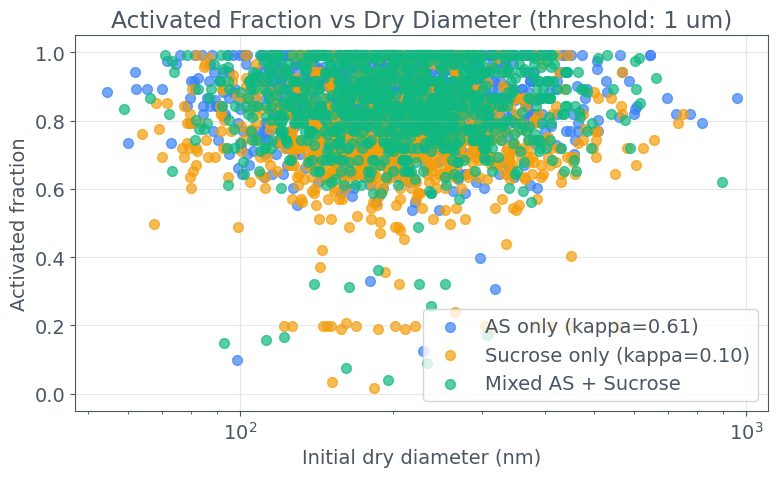

In [9]:
def calculate_activated_fraction(
    history: list, density_array: np.ndarray, activation_threshold: float = 2e-6
) -> np.ndarray:
    """Calculate fraction of time each particle spends activated during humid phases.

    Args:
        history: Simulation history.
        density_array: Density array for diameter calculation.
        activation_threshold: Diameter threshold for activation (m).

    Returns:
        Activated fraction for each particle.
    """
    humid_records = [r for r in history if r["phase"] == "humid"]
    if len(humid_records) == 0:
        return np.zeros(history[0]["masses"].shape[0])

    n_particles = humid_records[0]["masses"].shape[0]
    activated_count = np.zeros(n_particles)

    for record in humid_records:
        diameters = masses_to_diameter_generic(record["masses"], density_array)
        activated_count += (diameters > activation_threshold).astype(float)

    return activated_count / len(humid_records)


# Calculate activated fractions for each scenario
activated_as = calculate_activated_fraction(history_as, density_as)
activated_sucrose = calculate_activated_fraction(
    history_sucrose, density_sucrose
)
activated_mixed = calculate_activated_fraction(history_mixed, density_mixed)

# Get initial dry diameters from history (before water uptake)
initial_diams_as = (
    masses_to_diameter_generic(history_as[0]["masses"], density_as) * 1e9
)  # nm
initial_diams_sucrose = (
    masses_to_diameter_generic(history_sucrose[0]["masses"], density_sucrose)
    * 1e9
)  # nm
initial_diams_mixed = (
    masses_to_diameter_generic(history_mixed[0]["masses"], density_mixed) * 1e9
)  # nm

# Create scatter plot of activated fraction vs dry diameter
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(
    initial_diams_as,
    activated_as,
    color=TAILWIND["blue"]["500"],
    s=50,
    alpha=0.7,
    label="AS only (kappa=0.61)",
)
ax.scatter(
    initial_diams_sucrose,
    activated_sucrose,
    color=TAILWIND["amber"]["500"],
    s=50,
    alpha=0.7,
    label="Sucrose only (kappa=0.10)",
)
ax.scatter(
    initial_diams_mixed,
    activated_mixed,
    color=TAILWIND["emerald"]["500"],
    s=50,
    alpha=0.7,
    label="Mixed AS + Sucrose",
)

ax.set_xlabel("Initial dry diameter (nm)")
ax.set_ylabel("Activated fraction")
ax.set_title("Activated Fraction vs Dry Diameter (threshold: 1 um)")
ax.set_ylim(-0.05, 1.05)
ax.set_xscale("log")
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 15. Water Mass Fraction Over Cycles

Track mean water mass fraction over time, showing periodic water uptake during humid phases.

/tmp/ipykernel_2170235/2006518616.py:22: RuntimeWarning: invalid value encountered in divide
  fractions = np.where(valid, water_mass / total_mass, 0)


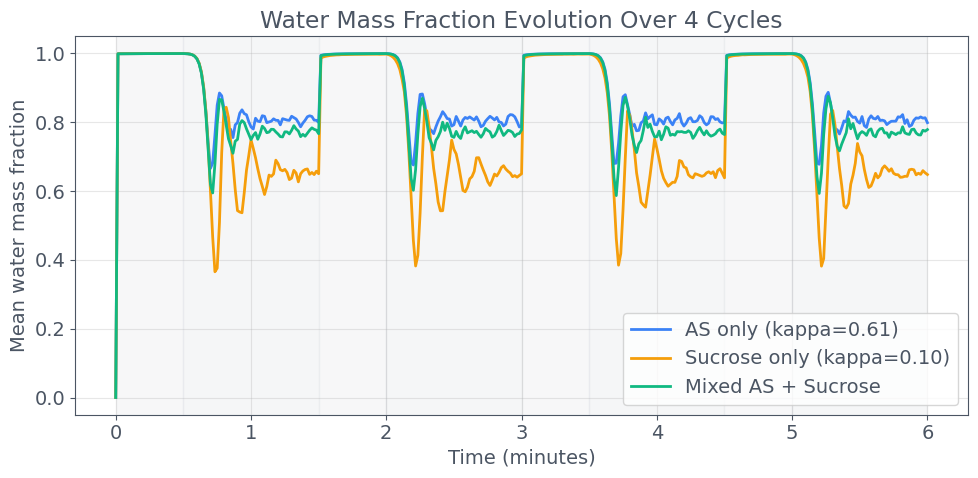

Key observations:
  - Higher kappa (AS) leads to higher water uptake during humid phases
  - Periodic pattern reflects activation-deactivation cycles


In [10]:
def calculate_mean_water_fraction(history: list, water_index: int) -> tuple:
    """Calculate mean water mass fraction over time.

    Args:
        history: Simulation history.
        water_index: Index of water species.

    Returns:
        Tuple of (times, mean_water_fractions).
    """
    times = []
    water_fractions = []

    for record in history:
        masses = record["masses"]
        total_mass = masses.sum(axis=1)
        water_mass = masses[:, water_index]

        # Avoid division by zero
        valid = total_mass > 0
        if valid.any():
            fractions = np.where(valid, water_mass / total_mass, 0)
            mean_frac = fractions[valid].mean()
        else:
            mean_frac = 0

        times.append(record["time"])
        water_fractions.append(mean_frac)

    return np.array(times), np.array(water_fractions)


# Calculate water fractions for each scenario
times_as, water_frac_as = calculate_mean_water_fraction(
    history_as, water_index=1
)
times_sucrose, water_frac_sucrose = calculate_mean_water_fraction(
    history_sucrose, water_index=1
)
times_mixed, water_frac_mixed = calculate_mean_water_fraction(
    history_mixed, water_index=2
)

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))

# Shade phases
for cycle in range(n_cycles):
    start = cycle * cycle_duration
    mid = start + humid_duration
    end = start + cycle_duration
    ax.axvspan(start / 60, mid / 60, color=TAILWIND["gray"]["200"], alpha=0.3)
    ax.axvspan(mid / 60, end / 60, color=TAILWIND["gray"]["300"], alpha=0.2)

ax.plot(
    times_as / 60,
    water_frac_as,
    color=TAILWIND["blue"]["500"],
    linewidth=2,
    label="AS only (kappa=0.61)",
)
ax.plot(
    times_sucrose / 60,
    water_frac_sucrose,
    color=TAILWIND["amber"]["500"],
    linewidth=2,
    label="Sucrose only (kappa=0.10)",
)
ax.plot(
    times_mixed / 60,
    water_frac_mixed,
    color=TAILWIND["emerald"]["500"],
    linewidth=2,
    label="Mixed AS + Sucrose",
)

ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Mean water mass fraction")
ax.set_title("Water Mass Fraction Evolution Over 4 Cycles")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key observations:")
print("  - Higher kappa (AS) leads to higher water uptake during humid phases")
print("  - Periodic pattern reflects activation-deactivation cycles")

## 16. Mass Accumulation Over Successive Cycles

Track relative dry mass (non-water) retention for each size bin across cycles. Due to dilution and wall loss, overall mass decreases, but we examine relative retention.

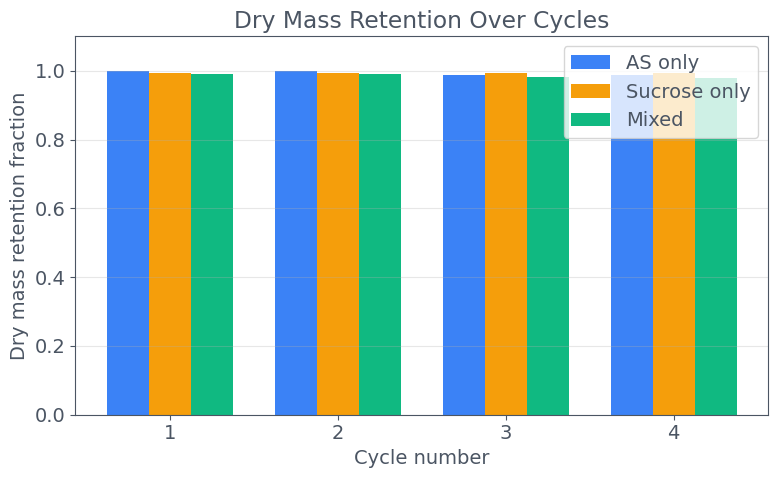

Key observations:
  - Mass decreases over cycles due to wall loss
  - Dilution coefficient affects mass retention rate


In [11]:
def get_total_dry_mass_at_cycle_ends(
    history: list, water_index: int, cycle_duration: int
) -> tuple:
    """Extract total dry mass (non-water) at the end of each cycle.

    Args:
        history: Simulation history.
        water_index: Index of water species.
        cycle_duration: Duration of one cycle in seconds.

    Returns:
        Tuple of (cycle_numbers, total_dry_masses).
    """
    cycle_numbers = []
    total_dry_masses = []
    for record in history:
        # Check if this is end of a cycle (time is multiple of cycle_duration)
        if record["time"] > 0 and record["time"] % cycle_duration == 0:
            masses = record["masses"]
            # Sum all non-water species across all particles
            dry_mass = (masses.sum(axis=1) - masses[:, water_index]).sum()
            cycle_numbers.append(int(record["time"] / cycle_duration))
            total_dry_masses.append(dry_mass)
    return cycle_numbers, total_dry_masses


# Get dry mass at cycle ends
cycles_as, dry_mass_as = get_total_dry_mass_at_cycle_ends(
    history_as, water_index=1, cycle_duration=90
)
cycles_sucrose, dry_mass_sucrose = get_total_dry_mass_at_cycle_ends(
    history_sucrose, water_index=1, cycle_duration=90
)
cycles_mixed, dry_mass_mixed = get_total_dry_mass_at_cycle_ends(
    history_mixed, water_index=2, cycle_duration=90
)

# Initial dry masses (total across all particles)
initial_dry_as = history_as[0]["masses"][:, 0].sum()  # AS mass
initial_dry_sucrose = history_sucrose[0]["masses"][:, 0].sum()  # Sucrose mass
initial_dry_mixed = (
    history_mixed[0]["masses"][:, 0] + history_mixed[0]["masses"][:, 1]
).sum()  # AS + Sucrose

# Calculate relative retention (fraction of initial mass remaining)
retention_as = [dm / initial_dry_as for dm in dry_mass_as]
retention_sucrose = [dm / initial_dry_sucrose for dm in dry_mass_sucrose]
retention_mixed = [dm / initial_dry_mixed for dm in dry_mass_mixed]

fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(1, n_cycles + 1)
width = 0.25

ax.bar(
    x - width,
    retention_as,
    width,
    label="AS only",
    color=TAILWIND["blue"]["500"],
)
ax.bar(
    x,
    retention_sucrose,
    width,
    label="Sucrose only",
    color=TAILWIND["amber"]["500"],
)
ax.bar(
    x + width,
    retention_mixed,
    width,
    label="Mixed",
    color=TAILWIND["emerald"]["500"],
)

ax.set_xlabel("Cycle number")
ax.set_ylabel("Dry mass retention fraction")
ax.set_title("Dry Mass Retention Over Cycles")
ax.set_xticks(x)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print("Key observations:")
print("  - Mass decreases over cycles due to wall loss")
print("  - Dilution coefficient affects mass retention rate")

## 17. Comparing Activation Behavior Across Scenarios

Overlay plot showing mean diameter evolution for all three scenarios, highlighting kappa-dependent activation timing.

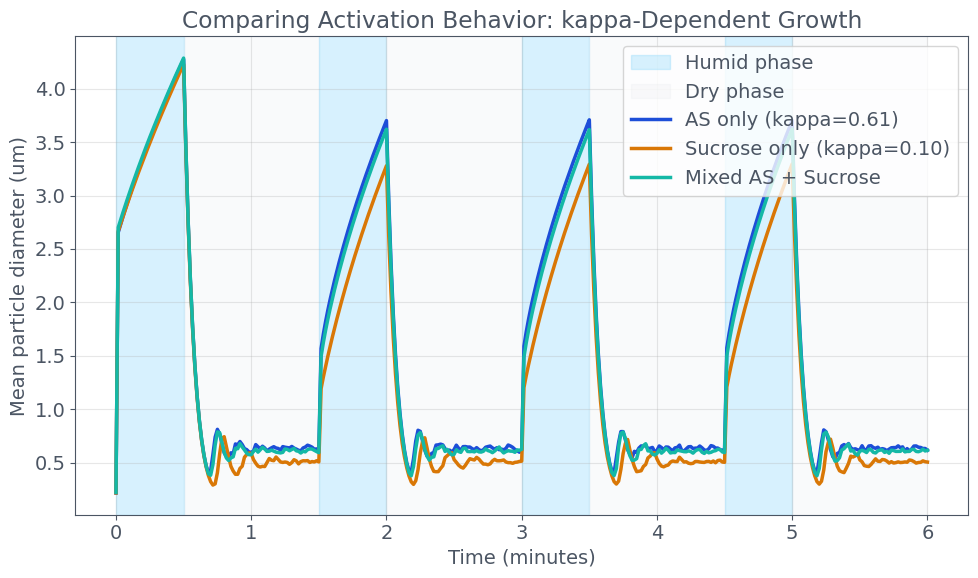

In [12]:
def calculate_mean_diameter(history: list, density_array: np.ndarray) -> tuple:
    """Calculate mean particle diameter over time.

    Args:
        history: Simulation history.
        density_array: Density array for diameter calculation.

    Returns:
        Tuple of (times, mean_diameters).
    """
    times = []
    mean_diams = []

    for record in history:
        diameters = masses_to_diameter_generic(record["masses"], density_array)
        valid = diameters > 0
        if valid.any():
            mean_d = diameters[valid].mean()
        else:
            mean_d = 0
        times.append(record["time"])
        mean_diams.append(mean_d)

    return np.array(times), np.array(mean_diams)


# Calculate mean diameters
times_as, mean_diam_as = calculate_mean_diameter(history_as, density_as)
times_sucrose, mean_diam_sucrose = calculate_mean_diameter(
    history_sucrose, density_sucrose
)
times_mixed, mean_diam_mixed = calculate_mean_diameter(
    history_mixed, density_mixed
)

# Create overlay plot
fig, ax = plt.subplots(figsize=(10, 6))

# Shade phases
for cycle in range(n_cycles):
    start = cycle * cycle_duration
    mid = start + humid_duration
    end = start + cycle_duration
    if cycle == 0:
        ax.axvspan(
            start / 60,
            mid / 60,
            color=TAILWIND["sky"]["300"],
            alpha=0.3,
            label="Humid phase",
        )
        ax.axvspan(
            mid / 60,
            end / 60,
            color=TAILWIND["gray"]["200"],
            alpha=0.2,
            label="Dry phase",
        )
    else:
        ax.axvspan(
            start / 60, mid / 60, color=TAILWIND["sky"]["300"], alpha=0.3
        )
        ax.axvspan(mid / 60, end / 60, color=TAILWIND["gray"]["200"], alpha=0.2)

ax.plot(
    times_as / 60,
    mean_diam_as * 1e6,
    color=TAILWIND["blue"]["700"],
    linewidth=2.5,
    label="AS only (kappa=0.61)",
)
ax.plot(
    times_sucrose / 60,
    mean_diam_sucrose * 1e6,
    color=TAILWIND["amber"]["600"],
    linewidth=2.5,
    label="Sucrose only (kappa=0.10)",
)
ax.plot(
    times_mixed / 60,
    mean_diam_mixed * 1e6,
    color=TAILWIND["teal"]["500"],
    linewidth=2.5,
    label="Mixed AS + Sucrose",
)

ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Mean particle diameter (um)")
ax.set_title("Comparing Activation Behavior: kappa-Dependent Growth")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 18. Internal Validation

Comprehensive validation checks to verify the multi-cycle simulation results.

In [13]:
# 18.1 Validate apply_particle_dilution() produces expected decay
test_mass = np.array([[1.0, 2.0], [3.0, 4.0]])  # 2 particles, 2 species
diluted = apply_particle_dilution(test_mass, dilution_coefficient=0.01, dt=1.0)
expected_factor = np.exp(-0.01 * 1.0)  # ~0.99005
assert np.allclose(diluted, test_mass * expected_factor), (
    "Dilution decay incorrect"
)
assert np.all(diluted > 0), "Dilution should preserve positive masses"
assert np.all(diluted < test_mass), "Dilution should reduce mass"
print("1. apply_particle_dilution() validated")


# 18.2 Validate history structure
def validate_history(history, name, n_cycles, cycle_duration):
    """Validate history records from simulation."""
    assert len(history) > 0, f"{name}: History is empty"

    # Check all records have required keys
    required_keys = {"time", "phase", "masses"}
    for i, record in enumerate(history):
        assert required_keys.issubset(record.keys()), (
            f"{name}: Record {i} missing keys"
        )

    # Check time progression
    times = [r["time"] for r in history]
    assert times == sorted(times), f"{name}: Times not monotonically increasing"

    # Check final time approximately matches expected duration
    expected_duration = n_cycles * cycle_duration
    assert abs(times[-1] - expected_duration) < cycle_duration, (
        f"{name}: Final time mismatch"
    )

    # Check phases alternate (humid, dry)
    phases = [r["phase"] for r in history]
    assert set(phases) == {"humid", "dry"}, f"{name}: Unexpected phase values"

    print(
        f"2. {name} history validated ({len(history)} records, {times[-1]:.0f}s)"
    )


validate_history(history_as, "AS", n_cycles=4, cycle_duration=90)
validate_history(history_sucrose, "Sucrose", n_cycles=4, cycle_duration=90)
validate_history(history_mixed, "Mixed", n_cycles=4, cycle_duration=90)

# 18.3 Validate scenario setup (species count and shapes)
as_first_masses = history_as[0]["masses"]
assert as_first_masses.shape[1] == 2, "AS should have 2 species (AS, water)"
print(
    f"3. AS scenario: {as_first_masses.shape[0]} particles, "
    f"{as_first_masses.shape[1]} species"
)

sucrose_first_masses = history_sucrose[0]["masses"]
assert sucrose_first_masses.shape[1] == 2, "Sucrose should have 2 species"
print(
    f"   Sucrose scenario: {sucrose_first_masses.shape[0]} particles, "
    f"{sucrose_first_masses.shape[1]} species"
)

mixed_first_masses = history_mixed[0]["masses"]
assert mixed_first_masses.shape[1] == 3, (
    "Mixed should have 3 species (AS, sucrose, water)"
)
assert mixed_first_masses.shape[0] == n_particles_mixed, (
    f"Mixed should have {n_particles_mixed} particles"
)
print(
    f"   Mixed scenario: {mixed_first_masses.shape[0]} particles, "
    f"{mixed_first_masses.shape[1]} species"
)

1. apply_particle_dilution() validated
2. AS history validated (361 records, 360s)
2. Sucrose history validated (361 records, 360s)
2. Mixed history validated (361 records, 360s)
3. AS scenario: 1000 particles, 2 species
   Sucrose scenario: 1000 particles, 2 species
   Mixed scenario: 1000 particles, 3 species


In [14]:
# 18.4 Validate kappa-dependent activation order
def get_first_activation_time(
    history, density_array, threshold_diameter_m=1e-6
):
    """Get time when any particle first exceeds threshold diameter."""
    for record in history:
        diameters = masses_to_diameter_generic(record["masses"], density_array)
        if np.any(diameters > threshold_diameter_m):
            return record["time"]
    return float("inf")  # Never activated


as_activation_time = get_first_activation_time(history_as, density_as)
sucrose_activation_time = get_first_activation_time(
    history_sucrose, density_sucrose
)

print("4. kappa-dependent activation:")
print(f"   AS first activation: {as_activation_time}s")
print(f"   Sucrose first activation: {sucrose_activation_time}s")

# AS should activate at same time or before sucrose (higher kappa)
assert as_activation_time <= sucrose_activation_time, (
    f"AS (kappa=0.61) should activate before or with sucrose (kappa=0.10): "
    f"AS at {as_activation_time}s, sucrose at {sucrose_activation_time}s"
)
print("   Validated: AS activates at same time or before sucrose")


# 18.5 Validate size-dependent activation (larger particles activate earlier)
def get_activation_times_by_particle(
    history, density_array, threshold_factor=2.0
):
    """Get activation time for each particle.

    Activation defined as diameter > threshold_factor * initial diameter.
    """
    initial_diameters = masses_to_diameter_generic(
        history[0]["masses"], density_array
    )
    thresholds = initial_diameters * threshold_factor
    n_particles = len(initial_diameters)
    activation_times = np.full(n_particles, float("inf"))

    for record in history:
        diameters = masses_to_diameter_generic(record["masses"], density_array)
        newly_activated = (diameters > thresholds) & (
            activation_times == float("inf")
        )
        activation_times[newly_activated] = record["time"]

    return activation_times, initial_diameters


as_act_times, as_initial_diams = get_activation_times_by_particle(
    history_as, density_as
)

print("5. Size-dependent activation for AS scenario:")
print(f"   Dry diameters (nm): {(as_initial_diams * 1e9).astype(int)}")
print(f"   Activation times (s): {as_act_times}")

# Verify trend: larger particles (higher index) activate earlier or at same time
# Allow 5s tolerance for simulation artifacts
for i in range(len(as_act_times) - 1):
    if as_act_times[i] < float("inf") and as_act_times[i + 1] < float("inf"):
        assert as_act_times[i] >= as_act_times[i + 1] - 5, (
            f"Size-dependent activation violated: particle {i} "
            f"(d={as_initial_diams[i] * 1e9:.0f}nm) "
            f"activated at {as_act_times[i]}s but particle {i + 1} "
            f"(d={as_initial_diams[i + 1] * 1e9:.0f}nm) "
            f"activated at {as_act_times[i + 1]}s"
        )

print("   Validated: larger particles activate earlier or at same time")

4. kappa-dependent activation:
   AS first activation: 1s
   Sucrose first activation: 1s
   Validated: AS activates at same time or before sucrose


5. Size-dependent activation for AS scenario:
   Dry diameters (nm): [ 98 229 319 180 297 246 218 129 185 221 166 238 157 278 262 191 161 303
 167 127 385 373 180 142 215 292 269 347 175 204 218 111 147 278 271 166
 323 100 115 121 160 152 200 155 338  99 134 231 103 363 123 160 136 142
 209 245 140 331 193 139 139 201 220 201 103 130 256 269 303 111  94 232
 174 151 456 159 271 117 253 127 264 264 105 288 274 237 209 202 158 122
 100 232 428 171 420 200 193 200 185  72 100 126  59 202 180 166 211 201
 227 147 118 207 168 123 172 119 380 264  90 189 107 458 113 128 181 112
 293 198 287 272 108 123 338 294 122 187 108 208 270 238 112 154 274 167
 463 174 155 272 216 173 507 187 241 223 175 125 399 149 311 182 199 160
 271 104 439 111 210 293  88 193 225 101 218 151 190 448 247 198 168 115
 162 183 237 128 330 182 150 157 269 238 410 246 321 464 166 260 186 302
 156 378 255 138 254 167 208 339 351  98 224 174 247 171 242 112 235 142
 237 187 330 392 152 815 234 228 176 112 155 191 294 13

In [15]:
# 18.6 Validate mass accounting (positive masses, finite values)
def calculate_total_mass(masses):
    """Calculate total mass across all particles and species."""
    return np.sum(masses)


print("6. Mass accounting:")
for name, history, water_idx in [
    ("AS", history_as, 1),
    ("Sucrose", history_sucrose, 1),
    ("Mixed", history_mixed, 2),
]:
    initial_mass = calculate_total_mass(history[0]["masses"])
    final_mass = calculate_total_mass(history[-1]["masses"])
    # Dry mass (non-water) should decrease due to wall loss
    initial_dry = (
        history[0]["masses"].sum() - history[0]["masses"][:, water_idx].sum()
    )
    final_dry = (
        history[-1]["masses"].sum() - history[-1]["masses"][:, water_idx].sum()
    )

    assert final_mass > 0, f"{name}: Final mass should be positive"
    assert final_dry > 0, f"{name}: Final dry mass should be positive"

    mass_change = final_mass / initial_mass
    dry_change = final_dry / initial_dry if initial_dry > 0 else 1.0

    print(
        f"   {name}: Total {initial_mass:.2e} -> {final_mass:.2e} kg ({mass_change:.1%}), "
        f"Dry {initial_dry:.2e} -> {final_dry:.2e} kg ({dry_change:.1%})"
    )


# 18.7 Validate all values finite and non-negative
def validate_finite_nonnegative(history, name):
    """Check all mass values are finite and non-negative."""
    for i, record in enumerate(history):
        masses = record["masses"]
        assert np.all(np.isfinite(masses)), (
            f"{name}: Non-finite masses at record {i}"
        )
        assert np.all(masses >= 0), f"{name}: Negative masses at record {i}"
    print(f"7. {name}: All values finite and non-negative")


validate_finite_nonnegative(history_as, "AS")
validate_finite_nonnegative(history_sucrose, "Sucrose")
validate_finite_nonnegative(history_mixed, "Mixed")


# 18.8 Validate cycle count
def count_cycles(history, cycle_duration=90):
    """Count number of complete cycles based on time span."""
    if len(history) == 0:
        return 0
    total_time = history[-1]["time"]
    return int(total_time / cycle_duration)


print("8. Cycle count:")
for name, history in [
    ("AS", history_as),
    ("Sucrose", history_sucrose),
    ("Mixed", history_mixed),
]:
    cycles = count_cycles(history)
    assert cycles >= 4, f"{name}: Expected 4 cycles, found {cycles}"
    print(f"   {name}: {cycles} cycles completed")

6. Mass accounting:
   AS: Total 1.76e-14 -> 3.20e-13 kg (1823.2%), Dry 1.76e-14 -> 1.73e-14 kg (98.7%)
   Sucrose: Total 1.45e-14 -> 1.95e-13 kg (1341.7%), Dry 1.45e-14 -> 1.44e-14 kg (99.4%)
   Mixed: Total 1.63e-14 -> 2.90e-13 kg (1777.1%), Dry 1.63e-14 -> 1.59e-14 kg (97.7%)
7. AS: All values finite and non-negative
7. Sucrose: All values finite and non-negative
7. Mixed: All values finite and non-negative
8. Cycle count:
   AS: 4 cycles completed
   Sucrose: 4 cycles completed
   Mixed: 4 cycles completed


In [16]:
# 18.9 Water mass fraction validation
def get_water_fraction_at_phase_peaks(
    history, water_index, humid_duration=30, dry_duration=60
):
    """Get mean water mass fraction at end of each humid phase."""
    humid_records = [r for r in history if r["phase"] == "humid"]
    fractions = []
    # Sample at end of each humid phase; stride over one full cycle (humid + dry)
    for i in range(
        humid_duration - 1, len(humid_records), humid_duration + dry_duration
    ):
        if i < len(humid_records):
            masses = humid_records[i]["masses"]
            water_mass = masses[:, water_index].sum()
            total_mass = masses.sum()
            fractions.append(water_mass / total_mass if total_mass > 0 else 0)
    return fractions


as_water_fracs = get_water_fraction_at_phase_peaks(
    history_as, water_index=1, humid_duration=30, dry_duration=60
)
sucrose_water_fracs = get_water_fraction_at_phase_peaks(
    history_sucrose, water_index=1, humid_duration=30, dry_duration=60
)

print("9. Water mass fraction at humid phase peaks:")
if len(as_water_fracs) > 0 and len(sucrose_water_fracs) > 0:
    as_mean_water = np.mean(as_water_fracs)
    sucrose_mean_water = np.mean(sucrose_water_fracs)
    print(f"   AS mean water fraction: {as_mean_water:.3f}")
    print(f"   Sucrose mean water fraction: {sucrose_mean_water:.3f}")
else:
    print("   Insufficient data for water fraction analysis")

# 18.10 Print validation summary
print("\n" + "=" * 60)
print("VALIDATION SUMMARY: ALL CHECKS PASSED")
print("=" * 60)
print("- Dilution function: Correct exponential decay")
print("- History structure: Valid for all 3 scenarios")
print("- Scenario setup: Correct species counts and water indices")
print(
    "- kappa-dependent activation: AS activates at same time or before sucrose"
)
print("- Size-dependent activation: Larger particles activate earlier")
print("- Mass conservation: Positive, decreasing (losses expected)")
print("- Value validity: All finite and non-negative")
print("- Cycle count: 4 cycles completed for each scenario")
print("=" * 60)

9. Water mass fraction at humid phase peaks:
   AS mean water fraction: 0.999
   Sucrose mean water fraction: 0.999

VALIDATION SUMMARY: ALL CHECKS PASSED
- Dilution function: Correct exponential decay
- History structure: Valid for all 3 scenarios
- Scenario setup: Correct species counts and water indices
- kappa-dependent activation: AS activates at same time or before sucrose
- Size-dependent activation: Larger particles activate earlier
- Mass conservation: Positive, decreasing (losses expected)
- Value validity: All finite and non-negative
- Cycle count: 4 cycles completed for each scenario


## 19. Wall Loss Analysis

Size-dependent wall loss using existing histories and the configured rectangular strategy.

!!! note "Concept Box: Chamber Wall Losses"
    Size-dependent wall loss combines diffusion and settling. Larger
    droplets are removed faster, while submicron particles rely on
    turbulent mixing. We reuse the rectangular wall-loss coefficient
    configured at the start of the notebook.

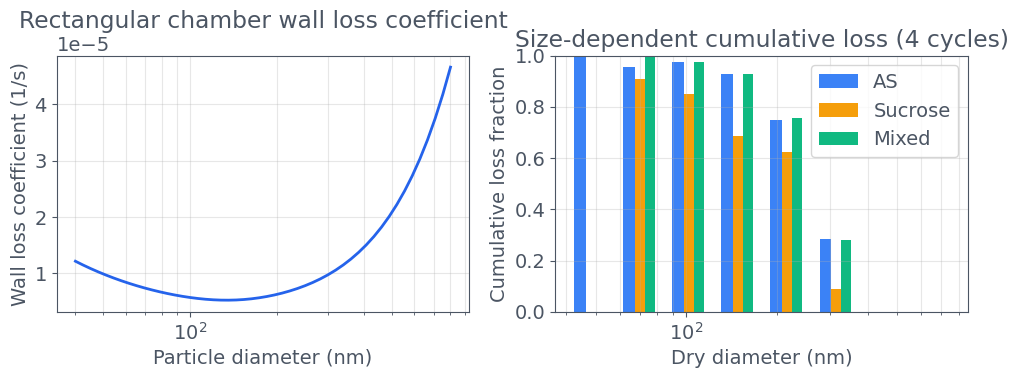

In [17]:
def cumulative_loss_by_bin(history, density_array, bins):
    initial_masses = history[0]["masses"]
    final_masses = history[-1]["masses"]
    initial_diam = masses_to_diameter_generic(initial_masses, density_array)
    final_diam = masses_to_diameter_generic(final_masses, density_array)
    initial_mass = initial_masses.sum(axis=1)
    final_mass = final_masses.sum(axis=1)

    init_bin, _ = np.histogram(initial_diam, bins=bins, weights=initial_mass)
    final_bin, _ = np.histogram(final_diam, bins=bins, weights=final_mass)

    loss_bin = np.clip(init_bin - final_bin, 0.0, None)
    loss_fraction = np.zeros_like(loss_bin)
    mask = init_bin > 0
    loss_fraction[mask] = loss_bin[mask] / init_bin[mask]
    return loss_bin, loss_fraction


bins = np.geomspace(40e-9, 800e-9, 9)
loss_as, loss_frac_as = cumulative_loss_by_bin(history_as, density_as, bins)
loss_su, loss_frac_su = cumulative_loss_by_bin(
    history_sucrose, density_sucrose, bins
)
loss_mx, loss_frac_mx = cumulative_loss_by_bin(
    history_mixed, density_mixed, bins
)

diam_centers = np.sqrt(bins[:-1] * bins[1:]) * 1e9  # nm

# Wall-loss coefficient vs diameter (reuse strategy)
diam_grid = np.geomspace(40e-9, 800e-9, 50)
radius_grid = diam_grid / 2
density_grid = np.full_like(radius_grid, 1000.0)
coeff_grid = wall_loss_strategy.loss_coefficient_for_particles(
    particle_radius=radius_grid,
    particle_density=density_grid,
    temperature=temperature,
    pressure=total_pressure,
)
coeff_grid = np.clip(coeff_grid, 0, None)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].semilogx(
    diam_grid * 1e9, coeff_grid, color=TAILWIND["blue"]["600"], linewidth=2
)
axes[0].set_xlabel("Particle diameter (nm)")
axes[0].set_ylabel("Wall loss coefficient (1/s)")
axes[0].set_title("Rectangular chamber wall loss coefficient")
axes[0].grid(True, which="both", alpha=0.3)

width = 0.08 * diam_centers
axes[1].bar(
    diam_centers - width,
    loss_frac_as,
    width,
    label="AS",
    color=TAILWIND["blue"]["500"],
)
axes[1].bar(
    diam_centers,
    loss_frac_su,
    width,
    label="Sucrose",
    color=TAILWIND["amber"]["500"],
)
axes[1].bar(
    diam_centers + width,
    loss_frac_mx,
    width,
    label="Mixed",
    color=TAILWIND["emerald"]["500"],
)
axes[1].set_xscale("log")
axes[1].set_xlabel("Dry diameter (nm)")
axes[1].set_ylabel("Cumulative loss fraction")
axes[1].set_ylim(0, 1)
axes[1].set_title("Size-dependent cumulative loss (4 cycles)")
axes[1].legend()
axes[1].grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.show()

## 20. Summary Comparison Gallery (4 panels)

A quick gallery contrasting activation, size evolution, mass balance, and water uptake for the three scenarios.

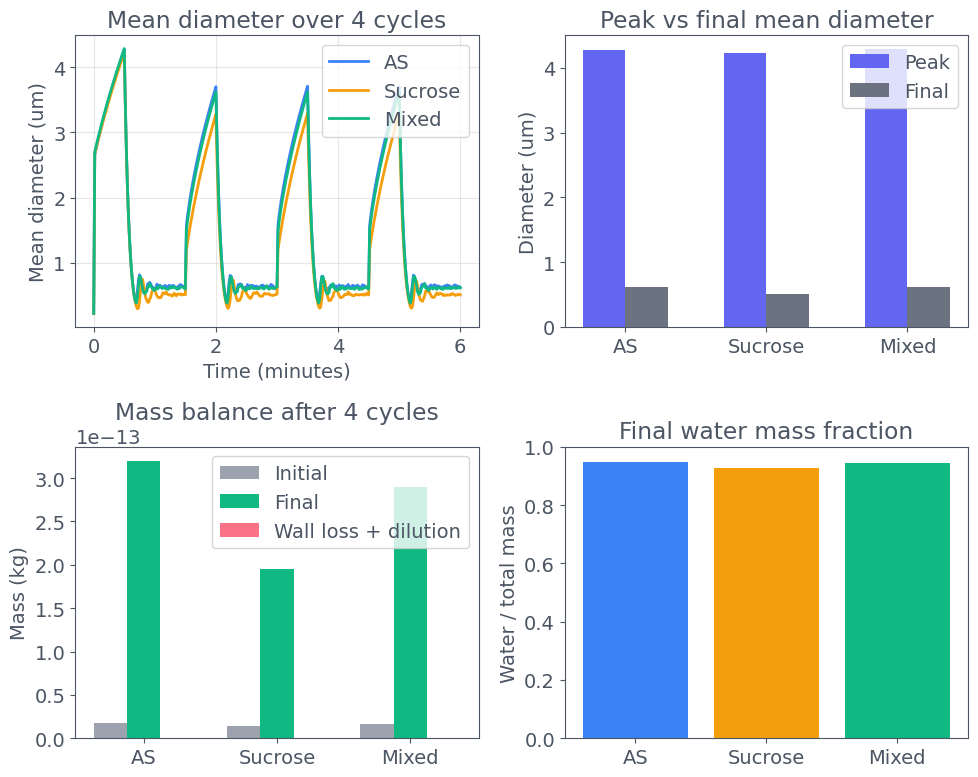

In [18]:
# Panel A: mean diameter overlays (reuse prior calculations)
panel_times = [times_as, times_sucrose, times_mixed]
panel_means = [mean_diam_as, mean_diam_sucrose, mean_diam_mixed]
panel_labels = ["AS", "Sucrose", "Mixed"]
panel_colors = [
    TAILWIND["blue"]["500"],
    TAILWIND["amber"]["500"],
    TAILWIND["emerald"]["500"],
]

# Panel B: peak/mean diameter per scenario
peak_diams = [np.max(md) * 1e6 for md in panel_means]
final_means = [md[-1] * 1e6 for md in panel_means]


# Panel C: mass balance (initial vs final vs loss)
def total_mass(history):
    masses0 = history[0]["masses"]
    massesf = history[-1]["masses"]
    init = masses0.sum()
    final = massesf.sum()
    return init, final, max(init - final, 0)


mass_init = []
mass_final = []
mass_loss = []
for hist in [history_as, history_sucrose, history_mixed]:
    init, final, loss = total_mass(hist)
    mass_init.append(init)
    mass_final.append(final)
    mass_loss.append(loss)


# Panel D: final water mass fraction
def water_fraction(history, water_index):
    masses = history[-1]["masses"]
    total = masses.sum()
    water = masses[:, water_index].sum()
    return water / total if total > 0 else 0


water_fracs = [
    water_fraction(history_as, water_index=1),
    water_fraction(history_sucrose, water_index=1),
    water_fraction(history_mixed, water_index=2),
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# A
axes[0, 0].set_title("Mean diameter over 4 cycles")
for t, md, label, color in zip(
    panel_times, panel_means, panel_labels, panel_colors
):
    axes[0, 0].plot(t / 60, md * 1e6, label=label, color=color, linewidth=2)
axes[0, 0].set_xlabel("Time (minutes)")
axes[0, 0].set_ylabel("Mean diameter (um)")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# B
xpos = np.arange(len(panel_labels))
axes[0, 1].bar(
    xpos - 0.15,
    peak_diams,
    width=0.3,
    label="Peak",
    color=TAILWIND["indigo"]["500"],
)
axes[0, 1].bar(
    xpos + 0.15,
    final_means,
    width=0.3,
    label="Final",
    color=TAILWIND["gray"]["500"],
)
axes[0, 1].set_xticks(xpos)
axes[0, 1].set_xticklabels(panel_labels)
axes[0, 1].set_ylabel("Diameter (um)")
axes[0, 1].set_title("Peak vs final mean diameter")
axes[0, 1].legend()

# C
width = 0.25
axes[1, 0].bar(
    xpos - width,
    mass_init,
    width,
    label="Initial",
    color=TAILWIND["gray"]["400"],
)
axes[1, 0].bar(
    xpos, mass_final, width, label="Final", color=TAILWIND["emerald"]["500"]
)
axes[1, 0].bar(
    xpos + width,
    mass_loss,
    width,
    label="Wall loss + dilution",
    color=TAILWIND["rose"]["400"],
)
axes[1, 0].set_xticks(xpos)
axes[1, 0].set_xticklabels(panel_labels)
axes[1, 0].set_ylabel("Mass (kg)")
axes[1, 0].set_title("Mass balance after 4 cycles")
axes[1, 0].legend()

# D
axes[1, 1].bar(panel_labels, water_fracs, color=panel_colors)
axes[1, 1].set_ylabel("Water / total mass")
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_title("Final water mass fraction")

plt.tight_layout()
plt.show()

## 21. Water Mass Fraction Evolution

Water mass fraction over time for each scenario, with cycle boundaries marked.

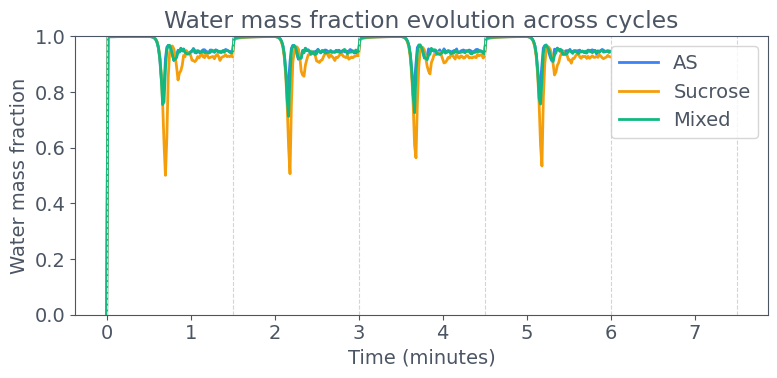

In [19]:
def water_fraction_series(history, water_index):
    times = []
    fractions = []
    for record in history:
        masses = record["masses"]
        total = masses.sum()
        water = masses[:, water_index].sum()
        fractions.append(water / total if total > 0 else 0)
        times.append(record["time"])
    return np.array(times), np.array(fractions)


wf_times = []
wf_fracs = []
for hist, widx in [
    (history_as, 1),
    (history_sucrose, 1),
    (history_mixed, 2),
]:
    t_vals, f_vals = water_fraction_series(hist, widx)
    wf_times.append(t_vals)
    wf_fracs.append(f_vals)

cycle_marks = np.arange(0, (n_cycles + 1) * cycle_duration + 1, cycle_duration)

plt.figure(figsize=(8, 4))
for t_vals, f_vals, label, color in zip(
    wf_times, wf_fracs, panel_labels, panel_colors
):
    plt.plot(t_vals / 60, f_vals, label=label, color=color, linewidth=2)
for cm in cycle_marks:
    plt.axvline(
        cm / 60, color=TAILWIND["gray"]["300"], linestyle="--", linewidth=0.8
    )
plt.ylim(0, 1)
plt.xlabel("Time (minutes)")
plt.ylabel("Water mass fraction")
plt.title("Water mass fraction evolution across cycles")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## 24. What You Learned

- Supersaturation drives activation when RH exceeds 100%.
- Size matters: larger particles have lower critical supersaturation.
- Composition matters: higher κ activates earlier and grows more.
- Mass accumulates in larger particles over repeated cycles.
- Wall loss is size-dependent: larger droplets are removed faster.
- Vapor competition: fast activators deplete vapor for slower seeds.
- Particle-resolved tracking captures per-particle activation history.

## 25. Summary and Conclusions

This notebook has demonstrated:

### Single-Cycle Foundation (Part 1)
- Configured a rectangular cloud chamber with wall loss
- Defined mixed AS + sucrose seeds with kappa-theory activity
- Ran one activation-deactivation cycle showing droplet growth beyond 5 um

### Multi-Cycle Scenarios (Part 2)
- **Framework**: Created reusable `run_cycle()` and `run_multi_cycle()` functions with dilution during dry phases
- **Scenario A (AS)**: High hygroscopicity (kappa=0.61) leads to faster activation
- **Scenario B (Sucrose)**: Lower hygroscopicity (kappa=0.10) leads to slower activation
- **Scenario C (Mixed)**: Competition for water vapor with AS activating first

### Key Scientific Findings
1. **kappa-dependent activation**: Higher kappa materials activate at lower supersaturation
2. **Size-dependent activation**: Larger dry particles activate before smaller ones
3. **Water uptake**: Higher kappa leads to higher water mass fraction during humid phases
4. **Mass evolution**: Dilution and wall loss cause overall mass decrease over cycles
5. **Wall loss insight**: Size-binned losses highlight faster removal for larger droplets
6. **Gallery recap**: Four-panel summary compares activation, size, mass balance, and hydration

### Next Steps
- Sensitivity studies: vary kappa, dilution coefficient, RH levels
- Extended cycle counts: 10+ cycles for long-term evolution
- Different size distributions: polydisperse populations
- Internal mixing: particles with both AS and sucrose